# Python Configuration

In [1]:
# python version:
from platform import python_version
print(f"python version = {python_version()}")

# We used the following version:
# python version = 3.8.6

python version = 3.8.5


In [2]:
# python standard library packages:
import importlib

# import more packages:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# import own package:
import functions as my

# the following package is only needed to view data interactively,
# otherwise you can comment the import out:
import qgrid  # https://github.com/quantopian/qgrid

In [3]:
# package versions:
print(f"numpy      version = {np.__version__}")
print(f"pandas     version = {pd.__version__}")
print(f"matplotlib version = {matplotlib.__version__}")

# the following package is only needed to view data interactively,
# otherwise you can comment this out:
print(f"qgrid      version = {qgrid.__version__}")

# We used the following versions:
# numpy      version = 1.19.2
# pandas     version = 1.1.3
# matplotlib version = 3.3.2
# qgrid      version = 1.3.1

numpy      version = 1.20.2
pandas     version = 1.2.5
matplotlib version = 3.3.4
qgrid      version = 1.3.1


# Raw Data Source

- **Source:** Login to [transparency.entsoe.eu](https://transparency.entsoe.eu/transmission-domain/r2/dayAheadPrices/show) after [registering for free](https://transparency.entsoe.eu/usrm/user/createPublicUser).
- **Download:** day-ahead prices `Day-ahead Prices_201601010000-201701010000.csv` by clicking `Day-ahead Prices (Year, CSV)` after selecting

    + area: DE-AT_LU
    + year: 2016

    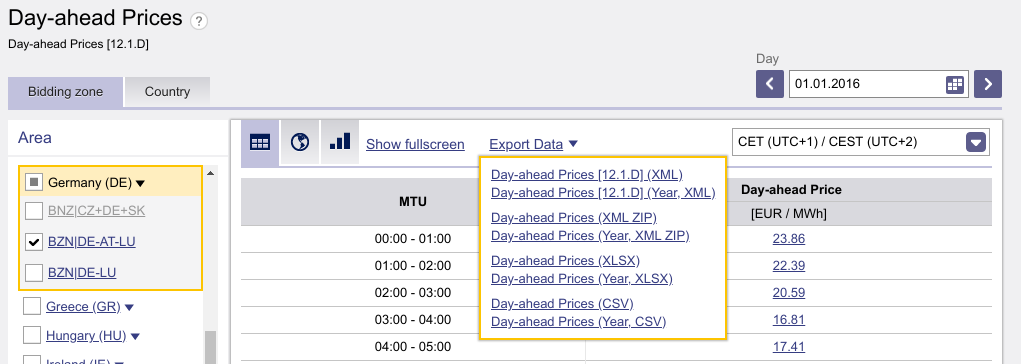
    
- time frame: years 2016
- sampling interval: 1 hour
- unit: EUR/MWh
- location: DE-AT_LU
- **legal notice:** [entsoe 2019 blog entry](https://www.entsoe.eu/news/2019/02/01/tsos-increase-number-of-open-data-available-through-entso-e-s-transparency-platform/) says "Indeed, the European TSOs agree to release their data into the platform under an open data licence. This facilitates the reuse of the data for new services, research and applications.", see also [this link](https://www.tscnet.eu/tsos-release-data-under-open-license/)

# Loading Raw Data

In [10]:
my_path = "../data/da/raw/"
my_file = "Day-ahead Prices_201601010000-201701010000.csv"

# "MTU (CET)","Day-ahead Price [EUR/MWh]"
# "27.01.2016 15:00 - 27.01.2016 16:00","23.91"
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
my_parser = lambda date: pd.to_datetime(date[:16], format='%d.%m.%Y %H:%M')

my_df = pd.read_csv(my_path + my_file,
                    date_parser=my_parser,
                    index_col="MTU (CET)"
                   )

# Processing of Raw Data

## View and Rename

In [11]:
# uncomment the following to get the output:
my_df.head(3)

,Day-ahead Price [EUR/MWh],BZN|DE-AT-LU
MTU (CET),,
2016-01-01 00:00:00,23.86,NaN
2016-01-01 01:00:00,22.39,NaN
2016-01-01 02:00:00,20.59,NaN


In [12]:
my_df.tail(3)

,Day-ahead Price [EUR/MWh],BZN|DE-AT-LU
MTU (CET),,
2016-12-31 21:00:00,33.02,NaN
2016-12-31 22:00:00,33.71,NaN
2016-12-31 23:00:00,27.95,NaN


In [13]:
# uncomment the following to get the output:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8785 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Day-ahead Price [EUR/MWh]  8784 non-null   float64
 1   BZN|DE-AT-LU               0 non-null      float64
dtypes: float64(2)
memory usage: 205.9 KB


In [17]:
# drop column "BZN|DE-AT-LU" 
my_df.drop(columns="BZN|DE-AT-LU", inplace=True)

In [18]:
# rename column:
my_df.columns = ['DA_EUR/MWh']

## Checks

In [19]:
my_ind = my_df.index.duplicated()  # -> time change on 2016-10-30
my_number_of_duplicates = my_df.loc[my_df.index[my_ind],].shape[0]
if my_number_of_duplicates > 0:
    print(f"Found {np.sum(my_number_of_duplicates)} duplicate timestamps!")

my_df.loc[my_df.index[my_ind],]

Found 2 duplicate timestamps!


,DA_EUR/MWh
MTU (CET),
2016-10-30 02:00:00,31.55
2016-10-30 02:00:00,31.55


In [20]:
# remove duplicates:
my_uniques = np.where(np.logical_not(my_ind))[0]
my_df = my_df.iloc[my_uniques,]

In [21]:
# check if all timestamps of the year are given:
print(f"{my_df.shape[0]} timestamps in data vs.\n{366*24} timestamps in 2016.")

8784 timestamps in data vs.
8784 timestamps in 2016.


In [24]:
# check for rows with a NaN value:
my_df[my_df.isna().any(axis=1)]

,DA_EUR/MWh
MTU (CET),


In [23]:
# fill NaN value with mean of neighours:
my_df.loc['2016-03-27 02:00:00','DA_EUR/MWh'] = (3.04 + 6.1)/2 

C:\Users\aulmer\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\aulmer\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [26]:
# check time changes in 2016 by visual inspection:
# qgrid.show_grid(my_df.loc['2016-03-27'])
# qgrid.show_grid(my_df.loc['2016-10-30'])

## Changes

In [27]:
# Resample to 15 minutes:
my_df_resampled = my_df['DA_EUR/MWh'].resample('15min').asfreq()
# my_df_resampled.tail()

In [28]:
# interpolate linearly:
my_df_resampled = my_df_resampled.interpolate('linear')
# my_df_resampled.tail()

In [29]:
# fill last hour with last value
my_df_resampled[pd.Timestamp('2016-12-31 23:15:00')] = 27.95
my_df_resampled[pd.Timestamp('2016-12-31 23:30:00')] = 27.95
my_df_resampled[pd.Timestamp('2016-12-31 23:45:00')] = 27.95
    
my_df_resampled.index[-1]

Timestamp('2016-12-31 23:45:00', freq='15T')

In [30]:
# make DataFrame:
my_df_resampled = my_df_resampled.to_frame()

In [31]:
# remove index name:
my_df_resampled.index.name = ""

In [32]:
my_df_resampled.head(3)

,DA_EUR/MWh
,
2016-01-01 00:00:00,23.8600
2016-01-01 00:15:00,23.4925
2016-01-01 00:30:00,23.1250


In [33]:
# importlib.reload(my);
my.checks(my_df_resampled, my_year='2016')

- check for rows with a NaN value: OK
- check for duplicate timestamps : OK
- check for set of timestamps    : OK


# Export of Processed Data

In [34]:
# export data to pickle:
my_df_resampled.to_pickle(
    '../data/da/processed/da_df.pickle')

if 0: # export data to csv:
    my_df_resampled.to_pickle(
        '../data/da/processed/da_df.csv')

# Some Plots

In [35]:
# load the processed data from pickle file:
my_df_resampled = pd.read_pickle('../data/da/processed/da_df.pickle')

<ipython-input-36-1fe4118a8dd4>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  my_df_resampled['2016-03-01'].plot(grid=True, figsize=(12,4), marker='.')


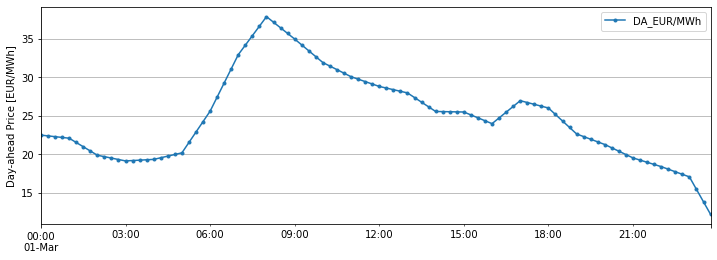

In [36]:
my_df_resampled['2016-03-01'].plot(grid=True, figsize=(12,4), marker='.')
plt.ylabel("Day-ahead Price [EUR/MWh]");

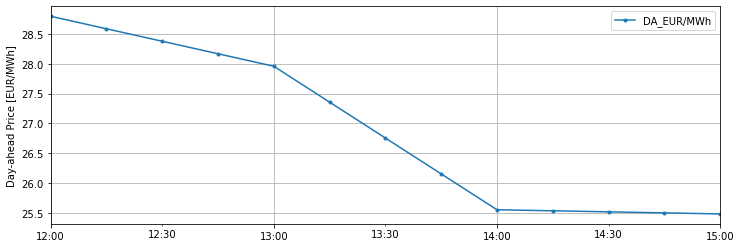

In [37]:
my_df_resampled['2016-03-01 12:00:00':'2016-03-01 15:00:00'].plot(
    grid=True, figsize=(12,4), marker='.')
plt.ylabel("Day-ahead Price [EUR/MWh]");